In [6]:
## Enviroment Setup
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Set the visible CUDA, here we use the second GPU
WORKING_DIR = '/home/peizhi/Documents/gaussian-dejavu/'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())
sys.path.append(WORKING_DIR)
sys.path.append('./models')
sys.path.append('./networks')
sys.path.append('./utils')
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/diff-gaussian-rasterization')
sys.path.append('./utils/gaussian_renderer')
sys.path.append('./utils/scene')
sys.path.append('./utils/arguments')
sys.path.append('./utils/simple-knn')

import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

import numpy as np
import cv2
import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.transforms import Resize
# import math
# from torch.optim.lr_scheduler import StepLR

# # Dejavu
# from models.gaussian_dejavu_base import Framework
# from utils.loss import *
# from utils.scene.cameras import PerspectiveCamera, prepare_camera
# from utils.viewer_utils import OrbitCamera
# from utils.gaussian_renderer import render
# from utils.graphics_utils import create_diff_world_to_view_matrix, verts_clip_to_ndc
# from utils.loss_utils import *

# ## FLAME
# from utils.flame_lib import dict2obj
# from utils.flame_lib.FLAME import FLAME



# GUI
from ipywidgets import interactive, interact, Layout
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import HBox, VBox, Label, Button


from dejavu import GaussianDejavu
from utils.personal_video_utils import *

def min_max_normalize(image):
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_image

dejavu = GaussianDejavu(network_weights='./models/dejavu_network.pt', uv_map_size=120, num_expressions=20)

device = dejavu.device


## load head avatar

dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='peizhi')
#dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject1')
#dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject2')



Current Working Directory:  /home/peizhi/Documents/gaussian-dejavu
creating the FLAME Decoder


/home/peizhi/Documents/gaussian-dejavu/utils/flame_lib/FLAME.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Documents/gaussian-dejavu/utils/flame_lib/FLAME.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/head_template2.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


Framework v3.1 initialized.
Number of Gaussians:  10694
model loaded from:  ./models/dejavu_network.pt
Gaussian DejaVu Framework Created.
Head avatar parameters loaded


## Personal Data Loader

Number of frames: 3077.
img torch.Size([3, 512, 512, 3])
parsing (3, 512, 512)
vertices (3, 5023, 3)
shape torch.Size([3, 100])
exp torch.Size([3, 50])
pose torch.Size([3, 6])
eye_pose torch.Size([3, 6])
tex torch.Size([3, 50])
light torch.Size([3, 9, 3])
cam torch.Size([3, 6])
img_masked torch.Size([3, 512, 512, 3])
masks torch.Size([3, 512, 512, 1])


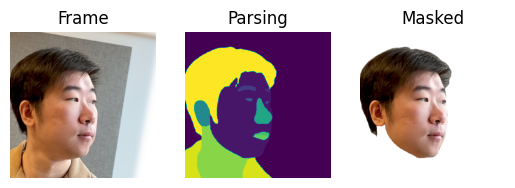

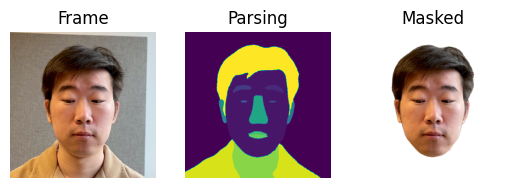

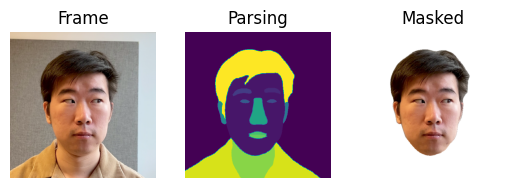

In [7]:
# Please first follow the flame-head-tracker to reconstruct the FLAME parameters  
# https://github.com/PeizhiYan/flame-head-tracker

dataset_path = '/mnt/data3_hdd/peizhi/Datasets/Personal_Videos_flame_new/peizhi-demo'
#dataset_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject1'
#dataset_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject2'
personal_dataloader = PersonalDataLoader(dataset_path=dataset_path, device=device, shuffle=True)

batch_data = personal_dataloader.next_random_batch(batch_size=3)

for key in batch_data:
    try:
        print(key, batch_data[key].shape)
    except:
        pass

for i in range(len(batch_data['fid'])):    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(batch_data['img'][i].detach().cpu()); plt.axis('off'); plt.title('Frame')
    plt.subplot(1,3,2)
    plt.imshow(batch_data['parsing'][i]); plt.axis('off'); plt.title('Parsing')
    plt.subplot(1,3,3)
    plt.imshow(batch_data['img_masked'][i].detach().cpu()); plt.axis('off'); plt.title('Masked')
    plt.show()


# dejavu._compute_average_uv_offsets_(personal_dataloader, batch_size=50)
# torch.save(dejavu.mean_shape_coefficients.cpu(), os.path.join('./saved_avatars/imavatar-subject2', 'mean_shape_coefficients.pt'))


In [ ]:

# dejavu._compute_average_uv_offsets_(personal_dataloader, batch_size=100)
# torch.save(dejavu.mean_exp_coefficients.cpu(), os.path.join('./saved_avatars/imavatar-subject2', 'mean_exp_coefficients.pt'))



/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Compare Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

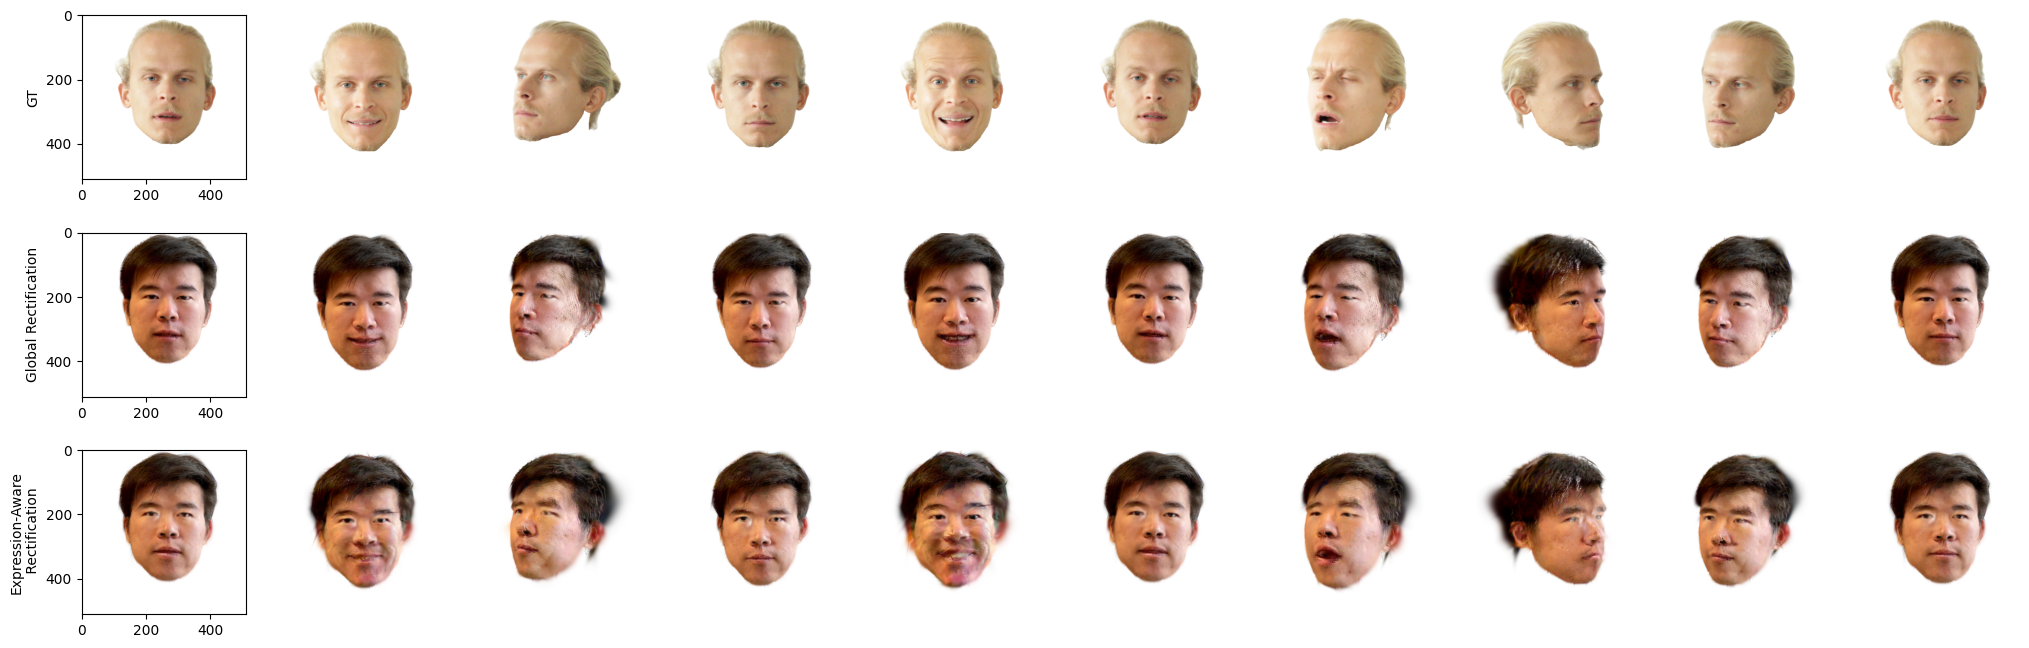

In [11]:

plt.figure(figsize=(25,8))

num_examples = 10
for i in range(num_examples):
    batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)

    # Ground-Truth Frames (First Row)
    plt.subplot(3,num_examples,i+1)
    plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('GT')

    # Reconstructed, w/ Global Rectification (Second Row)
    plt.subplot(3,num_examples,num_examples+i+1)
    batch_rendered_global = dejavu._render_with_global_offsets_(batch_data_test, dejavu.global_uv_delta)
    plt.imshow(batch_rendered_global[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Global Rectification')

    # Reconstructed, w/ Expression-Aware Rectification (Third Row)
    plt.subplot(3,num_examples,2*num_examples+i+1)
    batch_rendered_blend, _ = dejavu._render_with_blendmaps_(batch_data_test, dejavu.uv_delta_blendmaps)
    plt.imshow(batch_rendered_blend[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Expression-Aware\n Rectification')

plt.show()



In [ ]:
## Estimate fps

dt = time()
for _ in tqdm(range(100)):
    rendered = dejavu.drive_head_avatar()
dt = time() - dt
print(f'fps = {100 / dt}')


  0%|          | 0/100 [00:00<?, ?it/s]/home/peizhi/Documents/gaussian-dejavu/utils/scene/cameras.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  world_view_transform = torch.tensor(cam.world_view_transform).float().to(device)
/home/peizhi/Documents/gaussian-dejavu/utils/scene/cameras.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_proj_transform = torch.tensor(cam.full_proj_transform).float().to(device)
100%|██████████| 100/100 [00:01<00:00, 90.69it/s]

fps = 90.41242884632919


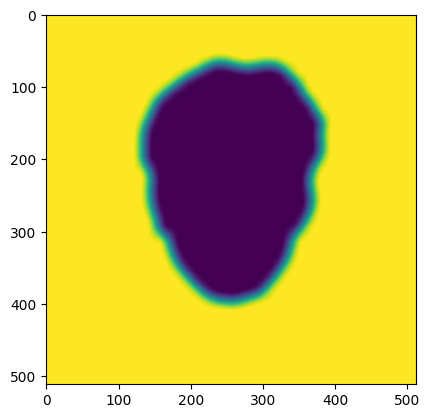

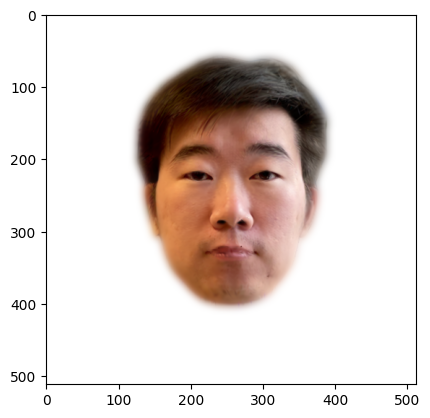

In [26]:
def blur_head_boundary(rendered_img, blur_kernel_size=25, erode_kernel_size=20, sigma=5):
    # rendered_img: RGB numpy array, float32
    # Ensure image is in 0-255 range if given in 0-1
    rendered_img = (np.clip(rendered_img, 0, 1.0) * 255).astype(np.uint8)

    # Create binary mask for head
    gray = cv2.cvtColor(rendered_img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

    # Erode mask to define boundary area
    eroded_mask = 255 - cv2.erode(binary_mask, np.ones((erode_kernel_size, erode_kernel_size), np.uint8), iterations=1)

    # Blur the boundary area
    blurred_boundary = cv2.GaussianBlur(rendered_img, (blur_kernel_size, blur_kernel_size), sigmaX=sigma, sigmaY=sigma)

    # Create alpha mask for blending
    alpha = cv2.GaussianBlur(eroded_mask.astype(float) / 255.0, (blur_kernel_size, blur_kernel_size), sigmaX=sigma*2)
    plt.imshow(alpha);plt.show()

    # Blend the original image with blurred boundary
    blurred_img = (alpha[..., None] * blurred_boundary + (1 - alpha[..., None]) * rendered_img)

    return blurred_img / 255.



batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)

exp = batch_data_test['exp'].cpu().numpy() 
pose = batch_data_test['pose'].cpu().numpy()
eye_pose = batch_data_test['eye_pose'].cpu().numpy()
cam_pose = batch_data_test['cam'].cpu().numpy()

#rendered = dejavu.drive_head_avatar(exp=exp, pose=pose, eye_pose=eye_pose, cam_pose=cam_pose, return_all=False)
rendered = dejavu.drive_head_avatar(exp=None, pose=None, eye_pose=None, cam_pose=None, return_all=False)

rendered = rendered[0].permute(1,2,0).cpu().numpy()

rendered = blur_head_boundary(rendered)


plt.imshow(rendered)
plt.show()


In [7]:
rendered.min()


tensor(0.0147, device='cuda:0')